In [1]:
import os

# 현재 작업 디렉토리 출력
print(os.getcwd())

# 작업 디렉토리 변경, 작업자 환경에 맞게 경로 수정
os.chdir('./tomato')

# 변경된 디렉토리 확인
print(os.getcwd())

/home/ghpf/Yoon/2023 sep. 비SCI/Computer vision/Data
/home/ghpf/Yoon/2023 sep. 비SCI/Computer vision/Data/tomato


In [4]:
from skimage import io, color, exposure, transform
from skimage.feature import hog
from sklearn import svm
import joblib
import numpy as np

# 1. 이미지 데이터 및 레이블 로드
image_paths = [
    "./tomato_test1.jpg", 
    "./tomato_test2.jpg",
    "./tomato_test3.jpg",
    "./cucumber_test2.jpeg",
    "./cucumber_test1.jpeg",
    "./cucumber_test3.jpg"
]
labels = [0, 0, 0, 1, 1, 1]  # 추정 0: tomato, 1: cucumber

# 2. HOG feature 추출
hog_features = []
for image_path in image_paths:
    image = io.imread(image_path)
    image = color.rgb2gray(image)
    
    # 2-1. Resize the image to a consistent size (e.g., 128x128)
    image = transform.resize(image, (128, 128))
    
    # 2-2. Compute HOG features
    fd = hog(image, orientations=10, pixels_per_cell=(8, 8),
             cells_per_block=(3, 3), visualize=False)
    hog_features.append(fd)

# Convert to NumPy array
hog_features = np.array(hog_features)

# 3. SVM 학습
clf = svm.SVC()
clf.fit(hog_features, labels)

# 4. 모델 저장 (선택사항)
joblib.dump(clf, 'tomato_svm_model.pkl')


['tomato_svm_model.pkl']

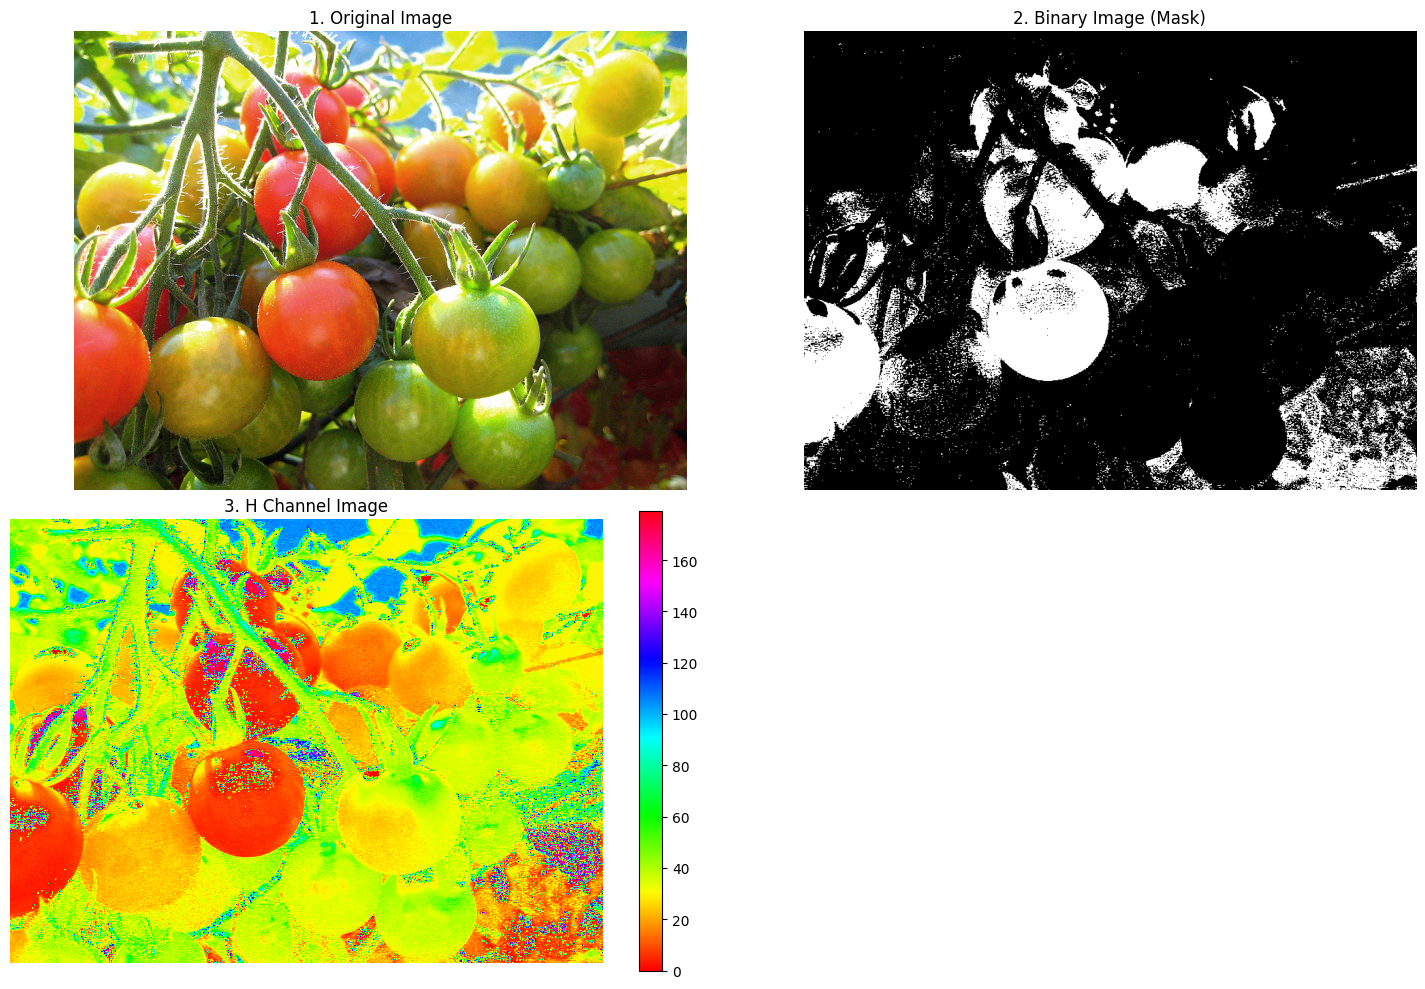

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('tomato.jpeg')

# 1. 원본 이미지
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("1. Original Image")
plt.axis('off')  # 축 정보 숨기기
plt.savefig('original_image.png')  # 저장하기


# 3. Binary 이미지 (mask 이미지라고 가정합니다)
hsv_tomato = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_tomato, (0, 50, 50), (20, 255, 255))

plt.subplot(2, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("2. Binary Image (Mask)")
plt.axis('off')  # 축 정보 숨기기
plt.savefig('binary_mask_image.png')  # 저장하기

# 4. H 채널 이미지와 스케일바
hue_channel = hsv_tomato[:, :, 0]

plt.subplot(2, 2, 3)
plt.imshow(hue_channel, cmap='hsv')
plt.title("3. H Channel Image")
plt.colorbar()
plt.axis('off')  # 축 정보 숨기기
plt.savefig('h_channel_image.png')  # 저장하기

plt.tight_layout()
plt.show()


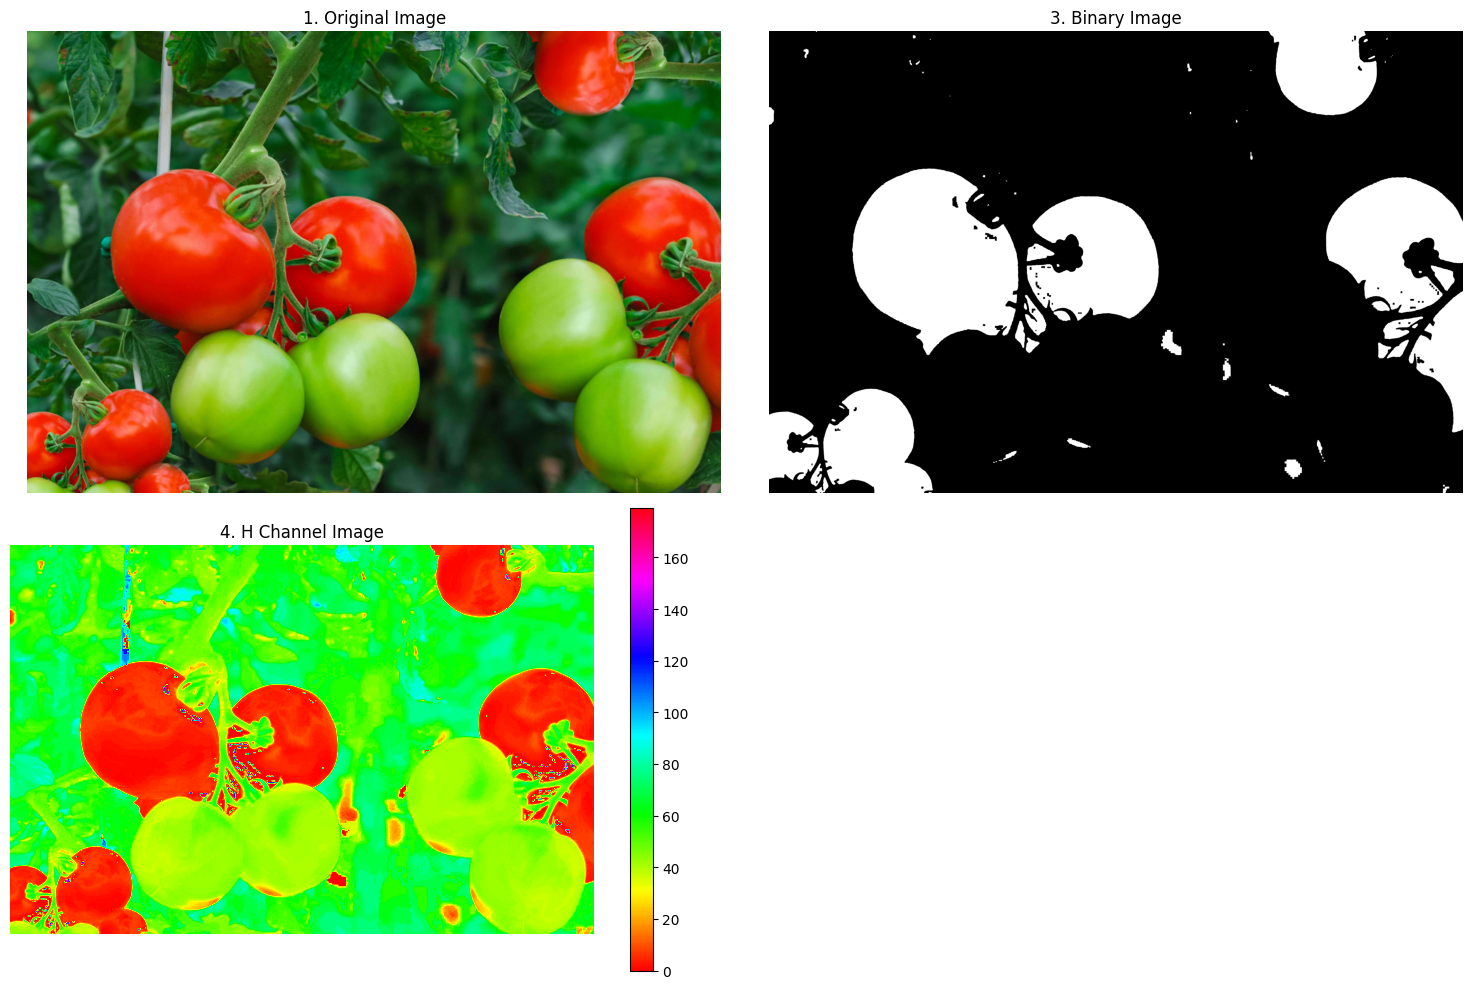

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('tomato2.jpeg')

# HSV 변환
hsv_tomato = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Mask 생성
mask = cv2.inRange(hsv_tomato, (0, 50, 50), (20, 255, 255))

# 모폴로지 연산을 사용하여 노이즈 제거
kernel = np.ones((5,5),np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)  # Opening to remove noise
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2) # Closing to fill holes

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Contour 영역의 크기를 기준으로 필터링
min_contour_area = 50  # 조절 가능한 값
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

# 원본 이미지에 contours 그리기
img_with_contours = img.copy()
cv2.drawContours(img_with_contours, contours, -1, (255, 0, 0), 2)

# 1. 원본 이미지
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("1. Original Image")
plt.axis('off')
#plt.savefig('original_image_2.png')

# 3. Binary 이미지 (mask 이미지)
plt.subplot(2, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("3. Binary Image")
plt.axis('off')
#plt.savefig('binary_mask_image_2.png')

# 3. H 채널 이미지와 스케일바
hue_channel = hsv_tomato[:, :, 0]
plt.subplot(2, 2, 3)
plt.imshow(hue_channel, cmap='hsv')
plt.title("4. H Channel Image")
plt.colorbar()
plt.axis('off')
#plt.savefig('h_channel_image_2.png')

plt.tight_layout()
plt.show()


Ripeness of detected tomatoes: Mature.


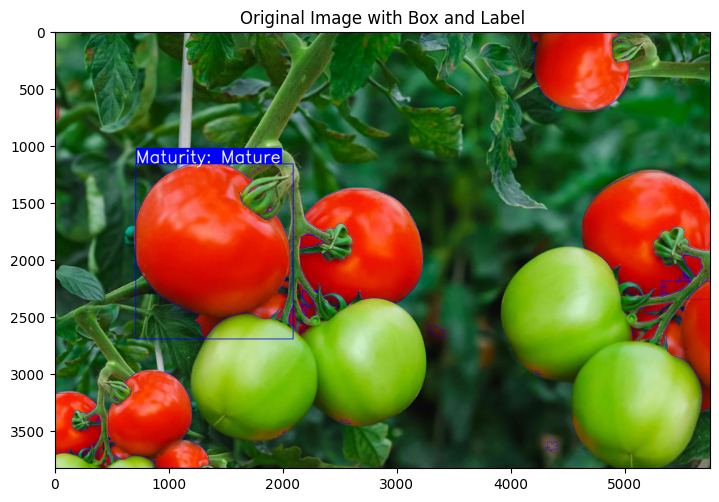

In [5]:
import cv2
import numpy as np
from skimage.feature import hog
import joblib
import matplotlib.pyplot as plt

# 학습된 SVM 모델 로드 (이미 학습한 경우)
clf = joblib.load('tomato_svm_model.pkl')

def extract_hog_features(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray_img, (128, 128))
    features = hog(resized_img, orientations=10, pixels_per_cell=(8, 8), cells_per_block=(3, 3), visualize=False)
    return features

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))

def detect_tomatoes_coarse_to_fine(img, clf):
    
    # 1. 노이즈 제거
    img = cv2.GaussianBlur(img, (5, 5), 0)
    
    # 4. 이미지 경계 처리
    border = 15
    img = cv2.copyMakeBorder(img, border, border, border, border, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    hsv_tomato = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_tomato, (0, 30, 50), (25, 255, 255))  # 색상 범위 변경

    # Opening to remove noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Closing to fill holes
    binary_img = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 2. 영역 크기 기준 제거
    min_contour_area = 100  # 조절 가능한 값
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    
    detections = [cv2.boundingRect(contour) for contour in contours]

    return detections


def assess_maturity_within_contour(tomato_img, contours):
    hsv_img = cv2.cvtColor(tomato_img, cv2.COLOR_BGR2HSV)
    
    mask = np.zeros_like(hsv_img[:, :, 0])
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
    
    hue_values = hsv_img[:, :, 0][mask == 255]
    mean_hue = np.mean(hue_values)

    if mean_hue < 10 or mean_hue > 160:
        return "Mature", hsv_img[:,:,0]
    elif 10 <= mean_hue <= 15:
        return "Breaker", hsv_img[:,:,0]
    else:
        return "Unmature", hsv_img[:,:,0]

img = cv2.imread('tomato2.jpeg')

# 이미지에서 토마토 검출
detections = detect_tomatoes_coarse_to_fine(img, clf)

for detection in detections:
    x, y, w, h = detection
    tomato = img[y:y+h, x:x+w]
    hsv_tomato = cv2.cvtColor(tomato, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_tomato, (0, 50, 50), (15, 255, 255))
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        maturity, hue_channel = assess_maturity_within_contour(tomato, [contour])
        cv2.drawContours(tomato, [contour], -1, (255, 0, 0), 2)

# 원본 이미지에 네모 박스 및 토마토 성숙도 이름표 추가
def draw_box_and_label(img, detection, maturity):
    x, y, w, h = detection
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 5)
    
    label_bg_color = (255, 0, 0)     # 박스의 배경색: 현재는 파란색
    label_text_color = (255, 255, 255)  # 박스의 텍스트 색상: 현재는 흰색
    font_scale = 5.0                 # 폰트 크기를 조절하는 변수. 크기를 조절하려면 이 값을 변경하세요.
    font_thickness = 10               # 텍스트 두께. 더 두꺼운 텍스트를 원하면 이 값을 증가시키세요.
    
    label_text = f"Maturity: {maturity}"
    (text_w, text_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(img, (x, y - 30 - text_h), (x + text_w, y), label_bg_color, -1)
    cv2.putText(img, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, label_text_color, font_thickness)


# 가장 큰 영역의 검출만 선택하기 위해 sort 사용
largest_detection = sorted(detections, key=lambda x: x[2]*x[3], reverse=True)[0]
x, y, w, h = largest_detection

# 가장 큰 박스 내부의 토마토 이미지 추출
tomato_inside_box = img[y:y+h, x:x+w]
hsv_tomato = cv2.cvtColor(tomato_inside_box, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_tomato, (0, 50, 50), (20, 255, 255))
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 박스 내부의 토마토 숙기 판단
maturity, hue_channel = assess_maturity_within_contour(tomato_inside_box, contours)

# 결과를 원본 이미지에 박스와 라벨로 그립니다.
draw_box_and_label(img, largest_detection, maturity)

print(f"Ripeness of detected tomatoes: {maturity}.")

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image with Box and Label")
#plt.savefig('original_image_tomato7.png')  # 저장하기

plt.tight_layout()
plt.show()